# Model performance

- Compute all metrics and figures used to evaluate model performance in the paper.
- Note that this notebook takes very long to run due to comparison of different ensembling methods.
    - The computed metrics from `Format predictions` and `Performance metrics` section have been saved in `data/publication/model_performance`.

In [1]:
import json
import os
from collections import Counter
from copy import deepcopy
import numpy as np
import pandas as pd
from math import ceil
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from cmcrameri import cm as cmap_cm
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score,
    precision_score,
    mean_absolute_error, 
    mean_squared_error,
    classification_report,
    r2_score
)
import sys
sys.path.append("../../")
from zeobind.src.utils.utils import setup_mpl
setup_mpl()
import warnings
warnings.filterwarnings("ignore")

# Utility functions

In [2]:
PAIR_COLS = ['Zeolite', 'SMILES']

In [3]:
def get_competition(df):
    """Given a matrix of energies, compute the competition energy on a per-row basis."""
    competition_energy = df.apply(lambda row: row.nsmallest(2).max(), axis=1)
    competition = df - competition_energy.values.reshape(-1, 1)
    return competition

In [4]:
cm = 1/2.54  # centimeters in inches

def save_mpl_fig(fig, basename, ending='.pdf', dpi=300):
    fig.savefig(basename + ending, bbox_inches='tight', dpi=dpi)

def format_axs(
    axs,
    xtick_size,
    ytick_size,
    spines_width,
    xlabel,
    ylabel,
    xlabel_size,
    ylabel_size,
    limits=None,
    tick_width=2, 
    tick_size=6, 
    bold_axs=False,
    xticks=None,
    yticks=None,
):
    
    if bold_axs:
        weight = 'bold'

    # Set tick labels
    if xticks is not None:
        axs.set_xticks(xticks)
    if yticks is not None:
        axs.set_yticks(yticks)

    axs.tick_params(axis="x", which="major", labelsize=xtick_size)
    axs.tick_params(axis="y", which="major", labelsize=ytick_size)
    axs.xaxis.set_tick_params(width=tick_width, size=tick_size)
    axs.yaxis.set_tick_params(width=tick_width, size=tick_size)

    # axs.tick_params(axis='both', which='minor="something", labelsize=8)
    for axis in ["top", "bottom", "left", "right"]:
        axs.spines[axis].set_linewidth(spines_width)

    axs.set_xlabel(xlabel, fontsize=xlabel_size)
    axs.set_ylabel(ylabel, fontsize=ylabel_size)
    
    if not limits:
        return axs
    if "x" in limits.keys():
        axs.set_xlim(limits["x"])
    if "y" in limits.keys():
        axs.set_ylim(limits["y"])
    
    return axs

def get_cb(fig, sc, axs, label, ticks=None, linewidth=2, tickwidth=2, labelsize=18, labelpad=20):
    '''Get colorbar'''
    cb = fig.colorbar(sc, ax=axs)
    cb.set_label(label, fontsize=labelsize)
    cb.outline.set_linewidth(linewidth)
    if ticks is not None:
        cb.set_ticks(ticks)
    cb.ax.tick_params(width=tickwidth)
    cb.ax.tick_params(labelsize=labelsize)
    # pad
    cb.ax.xaxis.labelpad = labelpad
    return cb

def get_legend(
    fig,
    bbox_to_anchor=(0.5, 1.1),
    fontsize=15,
    loc="upper center",
    ncol=2,
    axs=None,
    format_handles=False,
    legend_colors=None,
    linewidth=2,
    edgecolor="k",
    put_where="fig",
):
    '''Get legend.'''
    positions = {"fig": fig, "axs": axs}
    legend = positions[put_where].legend(
        fontsize=fontsize,
        loc=loc,
        bbox_to_anchor=bbox_to_anchor,
        ncol=ncol,
        frameon=False,
    )

    if format_handles:
        for idx, handle in enumerate(legend.legendHandles):
            handle.set_color(legend_colors[idx])
            handle.set_linewidth(linewidth)
            handle.set_edgecolor(edgecolor)

    return legend
    
def get_color_values(num_colors, c="viridis"):
    '''Get a list of color values from a colormap'''
    cmap = plt.cm.get_cmap(c)
    color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
    return color_values

def draw_parity(axs, xlimits, ylimits, lw=1):
    '''Draw a parity line on a plot'''
    limits = [min(xlimits[0], ylimits[0]), max(xlimits[1], ylimits[1])]
    axs.plot(limits, limits, "k--", lw=lw)
    return axs

def get_gridsize(limits, hex_length):
    """Given the length of the x and y axis, as well as length of the hexagon, return the appropriate gridsize input."""
    ny = ceil( (limits['y'][1] - limits['y'][0]) / hex_length)
    nx = ceil(np.sqrt(3) * ny)
    return (nx, ny)

In [5]:
def filter_substructures(smiles_list, keep_match=False, smarts='[r3]'):
    # Convert the SMARTS pattern to a RDKit molecule object
    pattern = Chem.MolFromSmarts(smarts)

    smis_noss = []
    smis_ss = []
    # Loop over the SMILES strings and check for 3-membered rings
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol.HasSubstructMatch(pattern):
            smis_ss.append(smiles)
        else:
            smis_noss.append(smiles)
    print(f'Number of molecules with and without 3-membered rings: {len(smis_ss), len(smis_noss)}')
    if keep_match:
        return smis_ss
    else:
        return smis_noss

def filter_double_bonds(smiles_list, keep_match=False):
    smis_noss = []
    smis_ss = []
    for smiles in smiles_list:
        m = Chem.MolFromSmiles(smiles)
        if any(m.GetBondWithIdx(idx).GetBondType().name == 'DOUBLE' for idx in range(m.GetNumBonds())):
            smis_ss.append(smiles)
        else:
            smis_noss.append(smiles)
    print(f'Number of molecules with and without double bonds: {len(smis_ss), len(smis_noss)}')
    if keep_match:
        return smis_ss
    else:
        return smis_noss
    
def show_mols(smis, legend=None, molsperrow=10, maxmols=50, subimgsize=(200, 200)):
    '''Show molecules in a grid.'''
    mols = [Chem.MolFromSmiles(smi) for smi in smis]
    if not legend:
        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=molsperrow,
            subImgSize=subimgsize,
            maxMols=maxmols,
        )
    else:
        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=molsperrow,
            subImgSize=subimgsize,
            maxMols=maxmols,
            legends=legend,
        )
    return img

In [6]:
def count_charge(smiles):
    return smiles.count("+]") - smiles.count("-]")

# Import files

In [7]:
data_dir = "../../data" 
main_op_dir = f"{data_dir}/publication/model_performance/"
os.makedirs(main_op_dir, exist_ok=True)

source_data_dir = "../../source_data"
os.makedirs(source_data_dir, exist_ok=True)

In [8]:
# read labels for training data
iza_truth = pd.read_csv(f"{data_dir}/datasets/training_data/training_data.csv", index_col=0)
print(iza_truth.shape)

(614263, 74)


In [9]:
# read labels for heldout data
heldout_truth = pd.read_csv(f"{data_dir}/datasets/heldout_hyp_mols/heldout_data.csv", index_col=0)
print(heldout_truth.shape)

(139615, 72)


In [10]:
heldout_truth["charge"] = heldout_truth["SMILES"].apply(count_charge)

In [11]:
# read molecule and framework feature names 
with open("../src/configs/osda_v1_phys.json", "r") as f:
    ofeatures = json.load(f).keys() 
with open("../src/configs/zeolite_v1_phys_short.json", "r") as f:
    zfeatures = json.load(f).keys() 

print(ofeatures)
print(zfeatures)

feature_dict = dict(
    mol_weight="$M_{mol} \; (g/mol)$",
    mol_volume="$V_{mol} \; (\AA^3)$",
    asphericity="Asphericity",
    eccentricity="Eccentricity",
    inertial_shape_factor="Inertial shape factor",
    spherocity_index="Spherocity",
    gyration_radius="$R_{gyration}$",
    pmi1="PMI 1",
    pmi2="PMI 2",
    pmi3="PMI 3",
    npr1="NPR 1",
    npr2="NPR 2",
    free_sasa="FSASA \; (\AA^2)$",
    bertz_ct="Bertz CT",
    num_rot_bonds="$N_{rot \; bonds}$",
    num_bonds="$N_{bonds}$",
    formal_charge="Charge",
    a="a", 
    b="b", 
    c="c", 
    alpha="$\alpha$", 
    beta="$\beta$", 
    gamma="$\gamma$", 
    num_atoms_per_vol="$N_{atoms} \; (1/\AA^3)$", 
    num_atoms="$N_{atoms}$", 
    volume="V_{fw} \; (\AA^3)$", 
    largest_free_sphere="D_{LFS} \; (\AA)$", 
    largest_free_sphere_a="D_{LFS,a} \; (\AA)$", 
    largest_free_sphere_b="D_{LFS,b} \; (\AA)$", 
    largest_free_sphere_c="D_{LFS,c} \; (\AA)$", 
    largest_included_sphere="D_{LIS} \; (\AA)$", 
    largest_included_sphere_a="D_{LIS,a} \; (\AA)$", 
    largest_included_sphere_b="D_{LIS,b} \; (\AA)$", 
    largest_included_sphere_c="D_{LIS,c} \; (\AA)$", 
    largest_included_sphere_fsp="D_{LIS,FSP} \; (\AA)$",
)

dict_keys(['mol_weight', 'mol_volume', 'asphericity', 'eccentricity', 'inertial_shape_factor', 'spherocity_index', 'gyration_radius', 'pmi1', 'pmi2', 'pmi3', 'npr1', 'npr2', 'free_sasa', 'bertz_ct', 'num_rot_bonds', 'num_bonds', 'formal_charge'])
dict_keys(['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'num_atoms_per_vol', 'num_atoms', 'volume', 'largest_free_sphere', 'largest_free_sphere_a', 'largest_free_sphere_b', 'largest_free_sphere_c', 'largest_included_sphere', 'largest_included_sphere_a', 'largest_included_sphere_b', 'largest_included_sphere_c', 'largest_included_sphere_fsp'])


In [12]:
# read training data features 
iza_opriors = pd.read_pickle(f"{data_dir}/datasets/training_data/osda_priors_0.pkl")
zpriors = pd.read_pickle(f"{data_dir}/datasets/training_data/zeolite_priors_0.pkl")
print(iza_opriors.shape, zpriors.shape)

(2974, 1667) (216, 1948)


In [13]:
# read heldout dataset features 
heldout_opriors = pd.read_pickle(f"{data_dir}/datasets/heldout_hyp_mols/osda_priors_0.pkl")[ofeatures]
print(heldout_opriors.shape)

(7477, 17)


In [14]:
# read data splits 
splits_dir = f"{data_dir}/datasets/training_data/splits"
splits = dict()
for i in range(1,6):
    splits[i] = dict(
        train=np.load(splits_dir + f'/{i}/' + 'smiles_train.npy'),
        val=np.load(splits_dir + f'/{i}/' + 'smiles_val.npy'),
        test=np.load(splits_dir + f'/{i}/' + 'smiles_test.npy'),
    )

for k, v in splits.items():
    print(k, {k: len(v) for k, v in v.items()})

1 {'train': 2360, 'val': 315, 'test': 299}
2 {'train': 2388, 'val': 287, 'test': 299}
3 {'train': 2390, 'val': 285, 'test': 299}
4 {'train': 2391, 'val': 284, 'test': 299}
5 {'train': 2370, 'val': 305, 'test': 299}


# Distribution of labels

In [15]:
# binary classification task
with open(main_op_dir + "/binary_labels.csv", "w") as f:
    f.write("Model,Set,Binding,Non_binding\n")
    for i in range(1,6):
        for task in ['Train', 'Val', 'Test']:
            ss = splits[i][task.lower()]
            tt = iza_truth[iza_truth['SMILES'].isin(ss)]
            line = f"{i},{task},{sum(tt.b == 1)},{sum(tt.nb == 1)}\n"
            f.write(line)

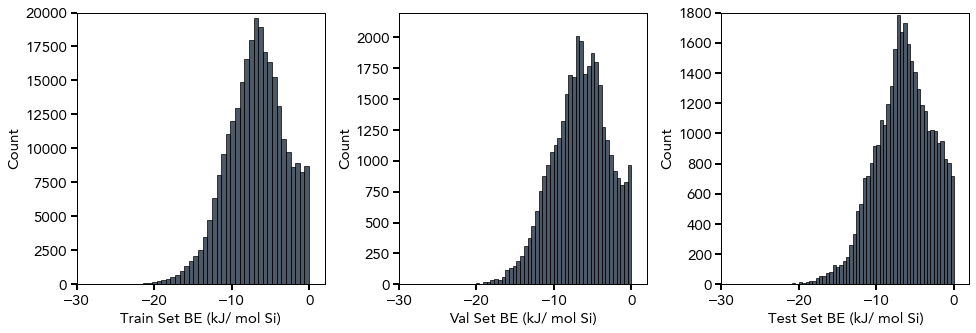

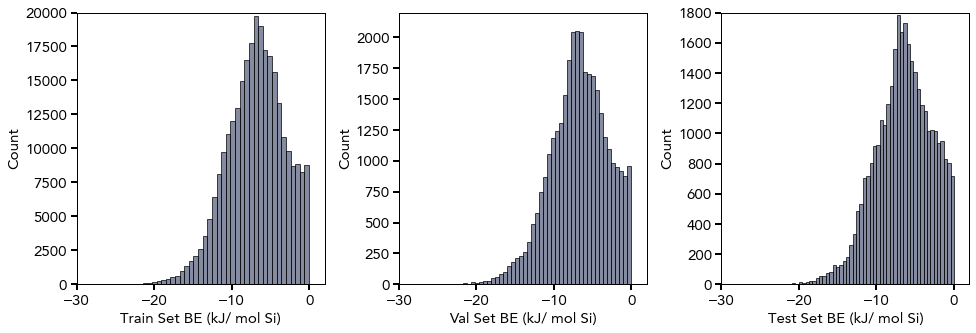

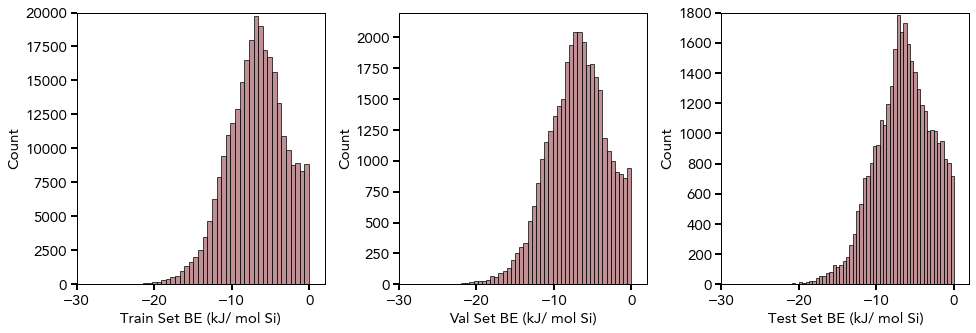

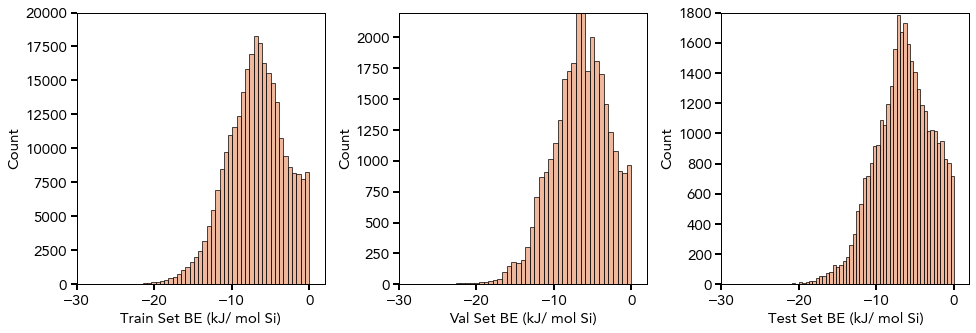

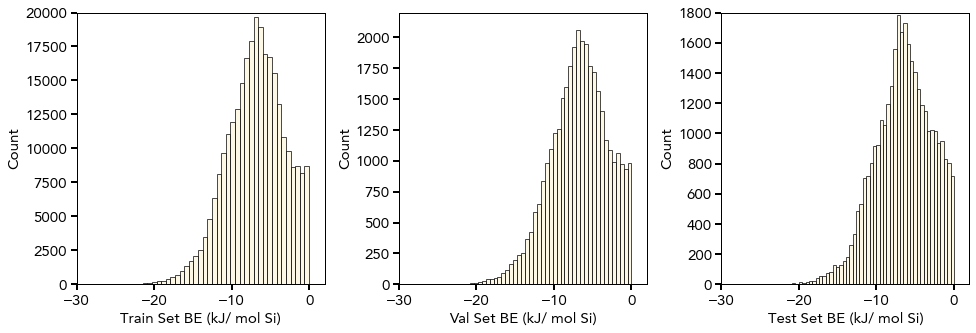

In [16]:
# energy task 
colors = get_color_values(5, cmap_cm.lipari)
limits = dict(
    train=dict(x=(-30, 2), y=(0, 20000)),
    val=dict(x=(-30, 2), y=(0, 2200)),
    test=dict(x=(-30, 2), y=(0, 1800)),
)
wspace = 0.3

for i in range(1, 6):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))

    for idx, task in enumerate(['Train', 'Val', 'Test']):

        ss = splits[i][task.lower()]    
        tt = iza_truth[
            (iza_truth['SMILES'].isin(ss))
            & (iza_truth['Binding (SiO2)'].lt(0.0))
            ]

        x = tt['Binding (SiO2)'].values
        kwargs = dict(edgecolor='k', color=colors[i-1], bins=50, alpha=0.7)
        axs[idx].hist(x, **kwargs)

        axs[idx] = format_axs(axs[idx], 15, 15, 1, f"{task} Set BE (kJ/ mol Si)", "Count", 15, 15, limits=limits[task.lower()], )
        plt.subplots_adjust(wspace=wspace)

    save_mpl_fig(fig, main_op_dir + f"/be_split_{i}_dist", ending='.svg', dpi=300)

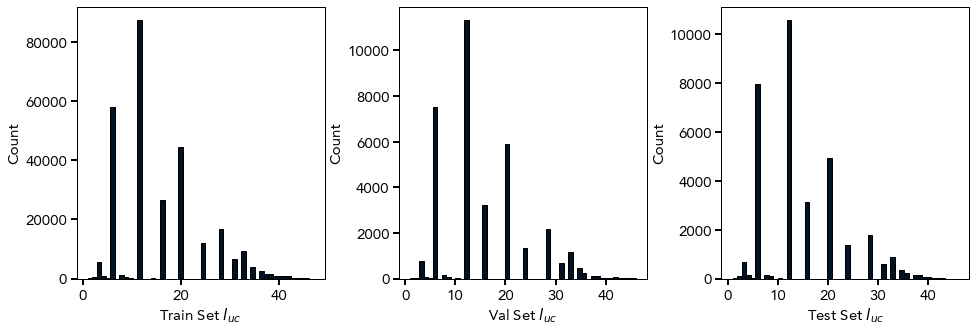

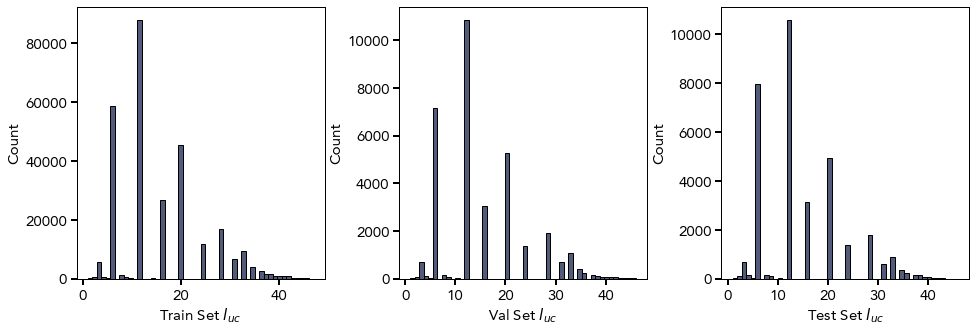

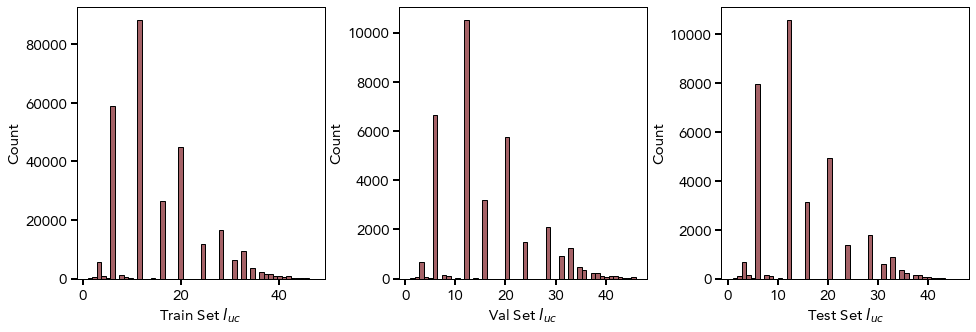

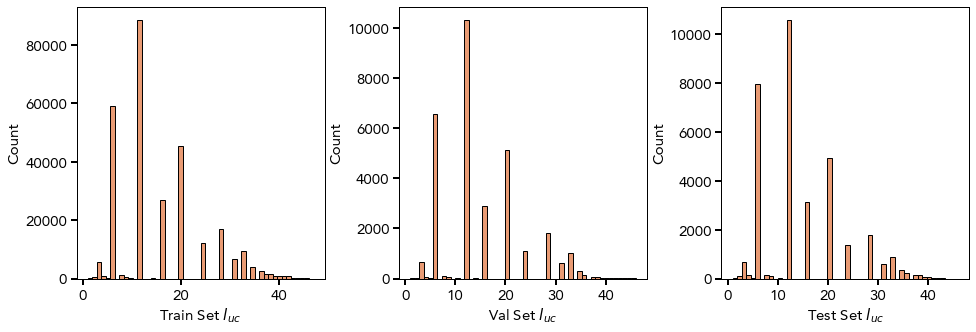

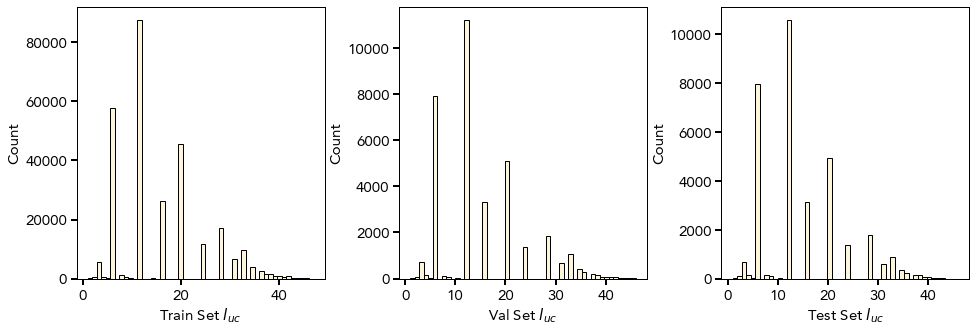

In [17]:
# loading task
# energy task 
colors = get_color_values(5, cmap_cm.lipari)
limits = dict(
    train=dict(x=(-30, 2), y=(0, 20000)),
    val=dict(x=(-30, 2), y=(0, 2200)),
    test=dict(x=(-30, 2), y=(0, 1800)),
)
wspace = 0.3

for i in range(1, 6):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))

    for idx, task in enumerate(['Train', 'Val', 'Test']):

        ss = splits[i][task.lower()]    
        tt = iza_truth[
            (iza_truth['SMILES'].isin(ss))
            & (iza_truth['Binding (SiO2)'].lt(0.0))
            ]

        x = tt['load_norm_class'].values
        kwargs = dict(edgecolor='k', color=colors[i-1], bins=50)
        axs[idx].hist(x, **kwargs)

        axs[idx] = format_axs(axs[idx], 15, 15, 1, task+" Set $l_{uc}$", "Count", 15, 15, ) #limits=limits[task.lower()], )
        plt.subplots_adjust(wspace=wspace)

    save_mpl_fig(fig, main_op_dir + f"/load_norm_class_split_{i}_dist", ending='.svg', dpi=300)

# Read predictions

In [18]:
import time 

def read_preds(parent_dir):
    start = time.time()
    print(os.listdir(parent_dir))

    efiles = [f for f in os.listdir(parent_dir + "/energy") if '.csv' in f]
    edfs = [pd.read_csv(parent_dir + "/energy/" + f, index_col=0) for f in efiles]
    edf = pd.concat(edfs, axis=0)
    print(f"{(time.time() - start) / 60} mins to read {edf.shape}")

    bfiles = [f for f in os.listdir(parent_dir + "/binary_likelihood") if '.csv' in f]
    bdfs = [pd.read_csv(parent_dir + "/binary_likelihood/" + f, index_col=0) for f in bfiles]
    bdf = pd.concat(bdfs, axis=0)
    print(f"{(time.time() - start) / 60} mins to read {bdf.shape}")

    befiles = [f for f in os.listdir(parent_dir + "/formatted_be") if '.csv' in f]
    mean_befiles = [f for f in befiles if 'mean' in f]
    std_befiles = [f for f in befiles if 'std' in f]
    mean_bedfs = [pd.read_csv(parent_dir + "/formatted_be/" + f, index_col=0) for f in mean_befiles]
    std_bedfs = [pd.read_csv(parent_dir + "/formatted_be/" + f, index_col=0) for f in std_befiles]
    mean_bedf = pd.concat(mean_bedfs, axis=0)
    std_bedf = pd.concat(std_bedfs, axis=0)
    print(f"{(time.time() - start) / 60} mins to read {mean_bedf.shape}")

    return dict(
        energy=edf,
        binary=bdf,
        mean_be=mean_bedf,
        std_be=std_bedf,
    )

iza_preds = read_preds(f"{data_dir}/predictions/training_data/")

['formatted_energy', 'energy', 'mclass', 'binary_likelihood', 'formatted_binary', 'formatted_be']
0.012556036313374838 mins to read (642816, 7)
0.02780572175979614 mins to read (642816, 12)
0.03330477873484294 mins to read (4061, 216)


In [19]:
iza_preds["mclass"] = pd.read_csv(f"{data_dir}/predictions/training_data/mclass/uncondensed/osda_priors_0_zeolite_priors_0_preds.csv")
print(iza_preds["mclass"].shape)

(614263, 233)


In [20]:
# read heldout preds
heldout_preds = read_preds(f"{data_dir}/predictions/heldout_hyp_mols/")

['formatted_energy', 'energy', 'mclass', 'binary_likelihood', 'formatted_binary', 'formatted_be']


0.004025777180989583 mins to read (139615, 7)
0.007421143849690755 mins to read (139615, 12)
0.009640777111053466 mins to read (5985, 216)


In [21]:
# read heldout mclass preds
heldout_preds["mclass"] = pd.read_csv(f"{data_dir}/predictions/heldout_hyp_mols/mclass/uncondensed/osda_priors_0_zeolite_priors_0_preds.csv", index_col=0)
print(heldout_preds["mclass"].shape)

(139615, 232)


In [22]:
# reformat be from mat into df
iza_preds['mean_be'] = iza_preds['mean_be'].unstack().dropna()
heldout_preds['mean_be'] = heldout_preds['mean_be'].unstack().dropna()

iza_preds['std_be'] = iza_preds['std_be'].unstack().dropna()
heldout_preds['std_be'] = heldout_preds['std_be'].unstack().dropna()

# Format predictions
- Different methods of combining ensemble b predictions, ensemble E predictions, and subsequently BE predictions are computed here.
- Competition energy is also computed from the final BE numbers

## Binary

In [15]:
binding_cols = ['binding (0)', 'binding (1)', 'binding (2)', 'binding (3)', 'binding (4)', 
                'binding (logits mean)', 'binding (logits min)', 'binding (logits max)', 
                'binding (mean)', 'binding (min)', 'binding (max)', 'binding (mode)']

In [23]:
def format_binary(bdf, blabel="binding"):
    """
    - `b` and `nb` - logits
        - (mean) - mean of logits
        - (min) - min of logits
        - (max) - max of logits
        - (std) - std of logits
    - `exp(b)` and `exp(nb)` - exponentiated logits
    - `denom` - sum of exponentiated logits
    - `softmax b` and `softmax nb` - exponentiated logits / sum of exponentiated logits
        - (mean) - mean of softmax probabilities
        - (min) - min of softmax probabilities
        - (max) - max of softmax probabilities
        - (std) - std of softmax probabilities
    - `binding` (or blabel) - class (0 or 1)
        - (logits mean) - from mean of logits
        - (logits min) - from min of logits
        - (logits max) - from max of logits
        - (mean) - from softmax (mean)
        - (min) - from softmax (min)
        - (max) - from softmax (max)
        - (mode) - compute class (0 or 1) for each model, then take the mode of that 
    
    - Note that taking the mean, min or max of the softmaxes means the sum of the softmaxes is not 1.    
    """
    start = time.time()
    num_models = range(5)

    # logits 
    bdf["b (mean)"] = bdf[[f"b ({i})" for i in num_models]].mean(axis=1)
    bdf["b (min)"] = bdf[[f"b ({i})" for i in num_models]].min(axis=1)
    bdf["b (max)"] = bdf[[f"b ({i})" for i in num_models]].max(axis=1)
    bdf["b (std)"] = bdf[[f"b ({i})" for i in num_models]].std(axis=1)
    bdf["nb (mean)"] = bdf[[f"nb ({i})" for i in num_models]].mean(axis=1)
    bdf["nb (min)"] = bdf[[f"nb ({i})" for i in num_models]].min(axis=1)
    bdf["nb (max)"] = bdf[[f"nb ({i})" for i in num_models]].max(axis=1)
    bdf["nb (std)"] = bdf[[f"nb ({i})" for i in num_models]].std(axis=1)
    print("logits done", round((time.time() - start) / 60,2))

    # binding from logits
    bdf[f'{blabel} (logits mean)'] = bdf["b (mean)"] > bdf["nb (mean)"]
    bdf[f'{blabel} (logits mean)'] = bdf[f'{blabel} (logits mean)'].apply(lambda x: 1 if x else 0)
    bdf[f'{blabel} (logits min)'] = bdf["b (min)"] > bdf["nb (min)"]
    bdf[f'{blabel} (logits min)'] = bdf[f'{blabel} (logits min)'].apply(lambda x: 1 if x else 0)
    bdf[f'{blabel} (logits max)'] = bdf["b (max)"] > bdf["nb (max)"]
    bdf[f'{blabel} (logits max)'] = bdf[f'{blabel} (logits max)'].apply(lambda x: 1 if x else 0)
    print(f"{blabel} from logits done", round((time.time() - start) / 60,2))

    # compute binding (1-5)
    for i in num_models:
        bdf[f"exp(b) ({i})"] = np.exp(bdf[f"b ({i})"])
        bdf[f"exp(nb) ({i})"] = np.exp(bdf[f"nb ({i})"])
        bdf[f"denom ({i})"] = bdf[f"exp(b) ({i})"] + bdf[f"exp(nb) ({i})"]
        bdf[f"softmax b ({i})"] = bdf[f"exp(b) ({i})"] / bdf[f"denom ({i})"]
        bdf[f"softmax nb ({i})"] = bdf[f"exp(nb) ({i})"] / bdf[f"denom ({i})"]
        bdf[f"{blabel} ({i})"] = bdf[f"softmax b ({i})"].apply(
            lambda x: 1 if x > 0.5 else 0
        )
    print(f"{blabel} (1-5) done", round((time.time() - start) / 60,2))
    
    # compute binding (mean)
    bdf['softmax b (mean)'] = bdf[[f"softmax b ({i})" for i in num_models]].mean(axis=1)
    bdf['softmax nb (mean)'] = bdf[[f"softmax nb ({i})" for i in num_models]].mean(axis=1)
    bdf[f'{blabel} (mean)'] = bdf['softmax b (mean)'] > bdf['softmax nb (mean)']
    bdf[f'{blabel} (mean)'] = bdf[f'{blabel} (mean)'].apply(lambda x: 1 if x else 0)
    print(f"{blabel} (mean) done", round((time.time() - start) / 60,2))

    # compute binding (min)
    bdf['softmax b (min)'] = bdf[[f"softmax b ({i})" for i in num_models]].min(axis=1)
    bdf['softmax nb (min)'] = bdf[[f"softmax nb ({i})" for i in num_models]].min(axis=1)
    bdf[f'{blabel} (min)'] = bdf['softmax b (min)'] > bdf['softmax nb (min)']
    bdf[f'{blabel} (min)'] = bdf[f'{blabel} (min)'].apply(lambda x: 1 if x else 0)
    print(f"{blabel} (min) done", round((time.time() - start) / 60,2))

    # compute binding (max)
    bdf['softmax b (max)'] = bdf[[f"softmax b ({i})" for i in num_models]].max(axis=1)
    bdf['softmax nb (max)'] = bdf[[f"softmax nb ({i})" for i in num_models]].max(axis=1)
    bdf[f'{blabel} (max)'] = bdf['softmax b (max)'] > bdf['softmax nb (max)']
    bdf[f'{blabel} (max)'] = bdf[f'{blabel} (max)'].apply(lambda x: 1 if x else 0)
    print(f"{blabel} (max) done", round((time.time() - start) / 60,2))

    # compute binding (mode)
    bdf[f'{blabel} (mode)'] = bdf[[f"{blabel} ({i})" for i in num_models]].mode(axis=1)
    print(f"{blabel} (mode) done", round((time.time() - start) / 60,2))

    # std 
    bdf['softmax b (std)'] = bdf[[f"softmax b ({i})" for i in num_models]].std(axis=1)
    bdf['softmax nb (std)'] = bdf[[f"softmax nb ({i})" for i in num_models]].std(axis=1)
    print("std done", round((time.time() - start) / 60,2))


    return bdf

In [24]:
bdf = deepcopy(heldout_preds["binary"])
bdf = format_binary(bdf)

logits done 0.0
binding from logits done 0.0
binding (1-5) done 0.01
binding (mean) done 0.01
binding (min) done 0.01
binding (max) done 0.01
binding (mode) done 0.31
std done 0.31


In [ ]:
heldout_preds["binary"] = bdf

In [27]:
bdf = deepcopy(iza_preds["binary"])
bdf = format_binary(bdf)

logits done 0.01
binding from logits done 0.02
binding (1-5) done 0.03
binding (mean) done 0.04
binding (min) done 0.05
binding (max) done 0.06
binding (mode) done 1.4
std done 1.4


In [28]:
iza_preds["binary"] = bdf

## Energy

In [29]:
def format_energy(edf, elabel="Binding (SiO2)"):
    """
    - `energy` - mean of energies
    - `min` - min of energies
    - `max` - max of energies
    - `std` - std of energies
    """
    start = time.time()
    num_models = range(5)
    edf[f"{elabel} (mean)"] = edf[[f"{elabel} ({i})" for i in num_models]].mean(axis=1)
    edf[f"{elabel} (min)"] = edf[[f"{elabel} ({i})" for i in num_models]].min(axis=1)
    edf[f"{elabel} (max)"] = edf[[f"{elabel} ({i})" for i in num_models]].max(axis=1)
    edf[f"{elabel} (std)"] = edf[[f"{elabel} ({i})" for i in num_models]].std(axis=1)
    print("energy done", round((time.time() - start) / 60,2))
    return edf

edf = deepcopy(heldout_preds["energy"])
edf = format_energy(edf)
heldout_preds["energy"] = edf 

energy done 0.0


In [30]:
edf = deepcopy(iza_preds["energy"])
edf = format_energy(edf)
iza_preds["energy"] = edf

energy done 0.0


## BE

In [31]:
def format_be(bdf, edf, pair_cols=PAIR_COLS, elabel="Binding (SiO2)", blabel="binding", belabel="BE"):
    # align the indices
    edf = edf.set_index(pair_cols)
    bdf = bdf.set_index(pair_cols)
    bedf = pd.concat([bdf, edf], axis=1)

    # compute be in all the different ways
    bes = dict()
    for b_mthd in [0, 1, 2, 3, 4, "logits min", "logits max", "logits mean", "min", "max", "mean", "mode"]:
        for e_mthd in [0, 1, 2, 3, 4, "min", "max", "mean"]:
            bes[f"{belabel} (b: {b_mthd}, e: {e_mthd})"] = bedf[f"{elabel} ({e_mthd})"] * bedf[f"{blabel} ({b_mthd})"]
    bedf = pd.concat([bedf, pd.DataFrame(bes)], axis=1)

    # ensembling the individual models 
    indiv_be_cols = [f"{belabel} (b: {i}, e: {i})" for i in range(5)]
    bedf[f"{belabel} (mean)"] = bedf[indiv_be_cols].mean(axis=1)
    bedf[f"{belabel} (min)"] = bedf[indiv_be_cols].min(axis=1)
    bedf[f"{belabel} (max)"] = bedf[indiv_be_cols].max(axis=1)
    bedf[f"{belabel} (std)"] = bedf[indiv_be_cols].std(axis=1)

    be_cols = [col for col in bedf.columns if belabel in col]
    bedf = bedf[be_cols]
    bedf = bedf.reset_index()

    return bedf


bdf = deepcopy(heldout_preds["binary"])
edf = deepcopy(heldout_preds["energy"])
bedf = format_be(bdf, edf)
heldout_preds["be"] = bedf

In [32]:
bdf = deepcopy(iza_preds["binary"])
edf = deepcopy(iza_preds["energy"])
bedf = format_be(bdf, edf)
iza_preds["be"] = bedf

## Mclass

In [33]:
def format_mclass(mdf, mlabel="load_norm_", class_label="loading_norm"):
    """
    - `load_norm_<class num>` - logits
        - (mean) - mean of logits
        - (min) - min of logits
        - (max) - max of logits
        - (std) - std of logits
    - `exp(load_norm_<class_num>)` - exponentiated logits
    - `denom` - sum of exponentiated logits
    - `softmax <class_num>` - exponentiated logits / sum of exponentiated logits
        - (mean) - mean of softmax probabilities
        - (min) - min of softmax probabilities
        - (max) - max of softmax probabilities
        - (std) - std of softmax probabilities
    - `loading_norm` 
        - (logits mean) - from mean of logits
        - (logits min) - from min of logits
        - (logits max) - from max of logits
        - (mean) - from softmax (mean)
        - (min) - from softmax (min)
        - (max) - from softmax (max)
        - (mode) - compute class for each model, then take the mode of that 
    
    - Note that taking the mean, min or max of the softmaxes means the sum of the softmaxes is not 1.    
    """
    start = time.time()
    num_models = range(5)
    num_classes = range(46)


    # logits 
    for c in num_classes:
        mdf[f"{mlabel}{c} (mean)"] = mdf[[f"{mlabel}{c} ({i})" for i in num_models]].mean(axis=1)
        mdf[f"{mlabel}{c} (min)"] = mdf[[f"{mlabel}{c} ({i})" for i in num_models]].min(axis=1)
        mdf[f"{mlabel}{c} (max)"] = mdf[[f"{mlabel}{c} ({i})" for i in num_models]].max(axis=1)
        mdf[f"{mlabel}{c} (std)"] = mdf[[f"{mlabel}{c} ({i})" for i in num_models]].std(axis=1)

    print("logits done", round((time.time() - start) / 60,2))

    # class from logits
    mdf[f'{class_label} (logits mean)'] = mdf[[f"load_norm_{c} (mean)" for c in num_classes]].idxmax(axis=1)
    mdf[f'{class_label} (logits mean)'] = mdf[f'{class_label} (logits mean)'].apply(lambda x: int(x.split('_')[2].split(' ')[0]))

    mdf[f'{class_label} (logits min)'] = mdf[[f"load_norm_{c} (min)" for c in num_classes]].idxmax(axis=1)
    mdf[f'{class_label} (logits min)'] = mdf[f'{class_label} (logits min)'].apply(lambda x: int(x.split('_')[2].split(' ')[0]))

    mdf[f'{class_label} (logits max)'] = mdf[[f"load_norm_{c} (max)" for c in num_classes]].idxmax(axis=1)
    mdf[f'{class_label} (logits max)'] = mdf[f'{class_label} (logits max)'].apply(lambda x: int(x.split('_')[2].split(' ')[0]))

    # compute class (1-5)
    for i in num_models:
        for c in num_classes:
            mdf[f"exp({mlabel}{c}) ({i})"] = np.exp(mdf[f"{mlabel}{c} ({i})"])
        mdf[f"denom ({i})"] = mdf[[f"exp({mlabel}{c}) ({i})" for c in num_classes]].sum(axis=1)
        for c in num_classes:
            mdf[f"softmax {c} ({i})"] = mdf[f"exp({mlabel}{c}) ({i})"] / mdf[f"denom ({i})"]
        # get the class 
        cols = [f"softmax {c} ({i})" for c in num_classes]
        mdf[f"{class_label} ({i})"] = mdf[cols].idxmax(axis=1)
        mdf[f'{class_label} ({i})'] = mdf[f'{class_label} ({i})'].apply(lambda x: int(x.split(' ')[1]))
    print(f"{class_label} (1-5) done", round((time.time() - start) / 60,2))
    
    # compute class (mean)
    for c in num_classes:
        mdf[f'softmax {c} (mean)'] = mdf[[f"softmax {c} ({i})" for i in num_models]].mean(axis=1)
    mdf[f'{class_label} (mean)'] = mdf[[f'softmax {c} (mean)' for c in num_classes]].idxmax(axis=1)
    mdf[f'{class_label} (mean)'] = mdf[f'{class_label} (mean)'].apply(lambda x: int(x.split(' ')[1]))
    print(f"{class_label} (mean) done", round((time.time() - start) / 60,2))

    # compute class (min)
    for c in num_classes:
        mdf[f'softmax {c} (min)'] = mdf[[f"softmax {c} ({i})" for i in num_models]].min(axis=1)
    mdf[f'{class_label} (min)'] = mdf[[f'softmax {c} (min)' for c in num_classes]].idxmax(axis=1)
    mdf[f'{class_label} (min)'] = mdf[f'{class_label} (min)'].apply(lambda x: int(x.split(' ')[1]))
    print(f"{class_label} (min) done", round((time.time() - start) / 60,2))

    # compute class (max)
    for c in num_classes:
        mdf[f'softmax {c} (max)'] = mdf[[f"softmax {c} ({i})" for i in num_models]].max(axis=1)
    mdf[f'{class_label} (max)'] = mdf[[f'softmax {c} (max)' for c in num_classes]].idxmax(axis=1)
    mdf[f'{class_label} (max)'] = mdf[f'{class_label} (max)'].apply(lambda x: int(x.split(' ')[1]))
    print(f"{class_label} (max) done", round((time.time() - start) / 60,2))

    # compute class (mode)
    # It is possible for there to be multiple modes, so we will keep all 
    mode_cols = [f"{class_label} (mode) ({i})" for i in num_models]
    mdf[mode_cols] = mdf[[f"{class_label} ({i})" for i in num_models]].mode(axis=1)
    print(f"{class_label} (mode) done", round((time.time() - start) / 60,2))

    # std 
    for c in num_classes:
        mdf[f'softmax {c} (std)'] = mdf[[f"softmax {c} ({i})" for i in num_models]].std(axis=1)
    print("std done", round((time.time() - start) / 60,2))

    return mdf

In [34]:
num_models = range(5)
load_cols = [f"loading_norm ({i})" for i in ["logits min", "logits max", "logits mean", "min", "max", "mean"]] + [f"loading_norm (mode) ({i})" for i in num_models]

In [35]:
# takes 3 mins 
mdf = deepcopy(heldout_preds["mclass"])
mdf = format_mclass(mdf)

logits done 0.65
loading_norm (1-5) done 0.76
loading_norm (mean) done 1.58
loading_norm (min) done 3.04
loading_norm (max) done 6.17
loading_norm (mode) done 6.65
std done 10.54


In [36]:
heldout_preds["mclass"] = mdf

In [ ]:
# This cell takes a while to run
mdf = deepcopy(iza_preds["mclass"])
mdf = format_mclass(mdf)

In [ ]:
iza_preds["mclass"] = mdf

## Save formatted predictions

In [ ]:
for k, v in iza_preds.items():
    output_file = f"{main_op_dir}/training_data_preds_{k}.csv"
    v.to_csv(output_file)

for k, v in heldout_preds.items():
    output_file = f"{main_op_dir}/heldout_data_preds_{k}.csv"
    v.to_csv(output_file)

In [ ]:
# Save only test set
for k, v in iza_preds.items():
    print(k)
    output_file = f"{main_op_dir}/training_data_preds_{k}_test.csv"
    try:
        to_save = v[v['SMILES'].isin(splits[5]['test'])]
    except KeyError:
        to_save = v[v.index.get_level_values('SMILES').isin(splits[5]['test'])]

    to_save.to_csv(output_file)

energy
binary
mean_be
std_be
mclass
be


# Load formatted predictions
- Load 

In [16]:
iza_preds = dict() 
heldout_preds = dict()

for k in ['energy', 'binary', 'mean_be', 'std_be', 'be', 'mclass']:
    iza_preds[k] = pd.read_csv(f"{main_op_dir}/training_data_preds_{k}_test.csv", index_col=0)
    heldout_preds[k] = pd.read_csv(f"{main_op_dir}/heldout_data_preds_{k}.csv", index_col=0)

# Performance metrics
- To compare ensembling methods, metrics are computed on the test set as each single model sees a different validation set, so computing metrics on a selected validation set would bias the results.

## b metrics

In [17]:
def get_avg_batched_metrics(x, y, func, batch_size=256, is_binary=False, ):
    """
    - Get the average of a metric computed on a batched dataset.
    - No shuffling.
    """
    metrics = [] 
    for i in range(0, len(x), batch_size):
        target = x[i:i+batch_size]
        input = y[i:i+batch_size]
        if is_binary:
            if input.sum().sum() == 0:
                # skip batch if all labels are 0 as precision would be 0
                continue
        metrics.append(func(target, input))
    return np.mean(metrics)

In [18]:
def get_binary_metrics(x, y, split=None, index_cols=PAIR_COLS, split_by="SMILES"):
    """
    - `split` is an iterable of `split_by` that the metrics are computed on
    """
    if split is not None:
        x = x[x[split_by].isin(split)]
    x = x.set_index(index_cols)
    y = y.set_index(index_cols)
    y = y.reindex(x.index)

    metrics = dict()
    metrics["accuracy"] = get_avg_batched_metrics(x, y, accuracy_score, is_binary=True)
    metrics["precision"] = get_avg_batched_metrics(x, y, precision_score, is_binary=True)
    metrics["f1"] = get_avg_batched_metrics(x, y, f1_score, is_binary=True)
    return metrics

In [23]:
# Training dataset binary metrics - test
binary_metrics = dict()
for c in binding_cols:
    x = deepcopy(iza_truth[PAIR_COLS + ["b"]])
    y = deepcopy(iza_preds["binary"][PAIR_COLS + [c]])
    binary_metrics[c] = get_binary_metrics(x, y, splits[1]["test"])

test_binary_metrics = pd.DataFrame.from_dict(binary_metrics)
test_binary_metrics.to_csv(main_op_dir + "/test_data_binary_metrics.csv")
test_binary_metrics.to_csv(source_data_dir + "/fig_3/c_test_data_binary_metrics.csv")

test_binary_metrics

,binding (0),binding (1),binding (2),binding (3),binding (4),binding (logits mean),binding (logits min),binding (logits max),binding (mean),binding (min),binding (max),binding (mode)
accuracy,0.964387,0.964408,0.965344,0.965107,0.963496,0.965917,0.965738,0.965986,0.965803,0.965965,0.965965,0.965465
precision,0.969359,0.966935,0.963529,0.963062,0.963555,0.966718,0.966948,0.966231,0.966615,0.966596,0.966596,0.966309
f1,0.967294,0.967418,0.968362,0.968184,0.966655,0.968836,0.968681,0.968903,0.968740,0.968895,0.968895,0.968434


In [ ]:
c = binding_cols[0]
x = heldout_truth[heldout_truth["charge"] == 1]
x = deepcopy(x[PAIR_COLS + ["b"]])
y = deepcopy(heldout_preds["binary"][PAIR_COLS + [c]])
x = x.set_index(PAIR_COLS)
y = y.set_index(PAIR_COLS).reindex(x.index)
for c in binding_cols:
    if c not in heldout_preds['binary'].columns:
        print(c)

In [ ]:
# Heldout set binary metrics by charge - monoquaternary
binary_metrics = dict()
for c in binding_cols:
    x = heldout_truth[heldout_truth["charge"] == 1]
    x = deepcopy(x[PAIR_COLS + ["b"]])
    y = deepcopy(heldout_preds["binary"][PAIR_COLS + [c]])
    binary_metrics[c] = get_binary_metrics(x, y, split=None)

heldout_binary_metrics_mono = pd.DataFrame.from_dict(binary_metrics)
heldout_binary_metrics_mono.to_csv(main_op_dir + "/heldout_data_binary_metrics_mono.csv")
heldout_binary_metrics_mono

,binding (0),binding (1),binding (2),binding (3),binding (4),binding (logits mean),binding (logits min),binding (logits max),binding (mean),binding (min),binding (max),binding (mode)
accuracy,0.951870,0.952858,0.952198,0.953109,0.953847,0.954644,0.953968,0.954781,0.954624,0.954473,0.954473,0.954573
precision,0.912461,0.916492,0.907245,0.908424,0.913539,0.916894,0.915917,0.913987,0.916731,0.915267,0.915267,0.916166
f1,0.913974,0.912372,0.909549,0.916152,0.917250,0.918292,0.917578,0.915283,0.918066,0.917679,0.917679,0.918333


In [ ]:
# Heldout set binary metrics by charge - diquarternary
binary_metrics = dict()
for c in binding_cols:
    x = deepcopy(heldout_truth[PAIR_COLS + ["b"]])
    y = deepcopy(heldout_preds["binary"][PAIR_COLS + [c]])
    binary_metrics[c] = get_binary_metrics(x, y, split=None)

heldout_binary_metrics_diq = pd.DataFrame.from_dict(binary_metrics)
heldout_binary_metrics_diq.to_csv(main_op_dir + "/heldout_data_binary_metrics_diq.csv")
heldout_binary_metrics_diq

,binding (0),binding (1),binding (2),binding (3),binding (4),binding (logits mean),binding (logits min),binding (logits max),binding (mean),binding (min),binding (max),binding (mode)
accuracy,0.933320,0.932782,0.932326,0.932863,0.935944,0.935059,0.934657,0.935449,0.935122,0.935130,0.935130,0.935136
precision,0.868175,0.865180,0.863932,0.856567,0.870987,0.869843,0.868450,0.866721,0.869812,0.868402,0.868402,0.869374
f1,0.885005,0.880661,0.882153,0.881788,0.888045,0.888080,0.886000,0.885076,0.888092,0.886411,0.886411,0.888635


## Energy helper functions

In [19]:
def rmse(x, y):
    return np.sqrt(np.mean((x.values - y.values) ** 2))

In [20]:
def get_avg_batched_val(x, y, split=None, index_cols=PAIR_COLS, split_by="SMILES", batch_size=256):
    """
    - Get the average of a metric computed on a batched dataset.
    - No shuffling.
    """
    if split is not None:
        x = x[x[split_by].isin(split)]
    x = x.set_index(index_cols)
    y = y.set_index(index_cols)
    y = y.reindex(x.index)

    metrics = [] 
    for i in range(0, len(y), batch_size):
        target = y[i:i+batch_size]
        metrics.append(target.mean())
    return np.mean(metrics)

In [21]:
def get_energy_metrics(x, y, split=None, index_cols=PAIR_COLS, split_by="SMILES"):
    """
    - `split` is an iterable of `split_by` that the metrics are computed on
    """
    if split is not None:
        x = x[x[split_by].isin(split)]
    x = x.set_index(index_cols)
    y = y.set_index(index_cols)
    y = y.reindex(x.index)
    # NOTE: No shuffling of data (see get_avg_batched_metrics)

    metrics = dict()
    metrics["rmse"] = get_avg_batched_metrics(x, y, rmse)
    metrics["mse"] = get_avg_batched_metrics(x, y, mean_squared_error)
    metrics["mae"] = get_avg_batched_metrics(x, y, mean_absolute_error)
    return metrics

## E metrics

In [22]:
energy_cols = [f"Binding (SiO2) ({i})" for i in [0, 1, 2, 3, 4, 'mean', 'min', 'max']]

In [ ]:
# Training dataset energy metrics - test
energy_metrics = dict()
for c in energy_cols:
    x = deepcopy(iza_truth[PAIR_COLS + ["Binding (SiO2)"]])
    y = deepcopy(iza_preds["energy"][PAIR_COLS + [c]])
    energy_metrics[c] = get_energy_metrics(x, y, splits[1]["test"])
    energy_metrics[c]["std_e"] = get_avg_batched_val(x, y, splits[1]["test"])

test_energy_metrics = pd.DataFrame.from_dict(energy_metrics)
test_energy_metrics.to_csv(main_op_dir + "/test_data_energy_metrics_test.csv")
test_energy_metrics.to_csv(source_data_dir + "fig_3/c_test_data_energy_metrics_test.csv")
test_energy_metrics 

,Binding (SiO2) (0),Binding (SiO2) (1),Binding (SiO2) (2),Binding (SiO2) (3),Binding (SiO2) (4),Binding (SiO2) (mean),Binding (SiO2) (min),Binding (SiO2) (max)
rmse,1.515001,1.460348,1.466008,1.460294,1.485443,1.455228,1.646798,1.349203
mse,2.309201,2.145187,2.161504,2.144253,2.218057,2.129284,2.727586,1.830252
mae,1.055952,1.023259,1.016357,1.025229,1.042432,1.020663,1.147829,0.948983
std_e,-4.133274,-4.042555,-4.031463,-4.069186,-4.113812,-4.078058,-4.350033,-3.808285


In [ ]:
# heldout set energy metrics - monoquaternary
energy_metrics = dict()
for c in energy_cols:
    x = heldout_truth[heldout_truth.charge == 1]
    x = deepcopy(x[PAIR_COLS + ["Binding (SiO2)"]])
    y = deepcopy(heldout_preds["energy"][PAIR_COLS + [c]])
    energy_metrics[c] = get_energy_metrics(x, y)
    energy_metrics[c]["std_e"] = get_avg_batched_val(x, y, None)

heldout_energy_metrics_mono = pd.DataFrame.from_dict(energy_metrics)
heldout_energy_metrics_mono.to_csv(main_op_dir + "/heldout_data_energy_metrics_mono.csv")
heldout_energy_metrics_mono

,Binding (SiO2) (0),Binding (SiO2) (1),Binding (SiO2) (2),Binding (SiO2) (3),Binding (SiO2) (4),Binding (SiO2) (mean),Binding (SiO2) (min),Binding (SiO2) (max)
rmse,1.334934,1.332643,1.349413,1.338412,1.326145,1.316983,1.405799,1.303046
mse,2.112330,2.118309,2.134266,2.130927,2.146025,2.066782,2.315076,2.076947
mae,0.949990,0.941683,0.962987,0.950119,0.943361,0.934583,1.005597,0.927586
std_e,-3.808383,-3.677503,-3.740241,-3.754744,-3.820213,-3.760217,-4.037804,-3.483719


In [ ]:
# heldout set energy metrics - diquaternary
energy_metrics = dict()
for c in energy_cols:
    x = heldout_truth[heldout_truth.charge == 2]
    x = deepcopy(x[PAIR_COLS + ["Binding (SiO2)"]])
    y = deepcopy(heldout_preds["energy"][PAIR_COLS + [c]])
    energy_metrics[c] = get_energy_metrics(x, y)
    energy_metrics[c]["std_e"] = get_avg_batched_val(x, y, None)

heldout_energy_metrics_diq = pd.DataFrame.from_dict(energy_metrics)
heldout_energy_metrics_diq.to_csv(main_op_dir + "/heldout_data_energy_metrics_diq.csv")
heldout_energy_metrics_diq

,Binding (SiO2) (0),Binding (SiO2) (1),Binding (SiO2) (2),Binding (SiO2) (3),Binding (SiO2) (4),Binding (SiO2) (mean),Binding (SiO2) (min),Binding (SiO2) (max)
rmse,2.587043,2.415841,2.440188,2.392414,2.453333,2.425683,2.828793,2.119084
mse,7.605378,6.793811,6.898467,6.687610,6.955314,6.810327,9.049917,5.337487
mae,2.060296,1.903633,1.909115,1.884966,1.933564,1.925323,2.270133,1.656557
std_e,-3.844774,-3.643641,-3.632499,-3.598630,-3.662587,-3.676426,-4.166870,-3.209868


## BE metrics

In [23]:
be_cols = [c for c in heldout_preds['be'].columns if 'BE' in c]

In [ ]:
# Training dataset BE metrics - test
energy_metrics = dict()
for c in be_cols:
    x = deepcopy(iza_truth[PAIR_COLS + ["Binding (SiO2)"]])
    y = deepcopy(iza_preds["be"][PAIR_COLS + [c]])
    energy_metrics[c] = get_energy_metrics(x, y, splits[1]["test"])
    energy_metrics[c]["std_e"] = get_avg_batched_val(x, y, splits[1]["test"])

test_be_metrics = pd.DataFrame.from_dict(energy_metrics)
test_be_metrics.to_csv(main_op_dir + "/test_data_be_metrics.csv")
test_be_metrics.to_csv(source_data_dir + "fig_3/c_test_data_be_metrics.csv")
test_be_metrics

,"BE (b: 0, e: 0)","BE (b: 0, e: 1)","BE (b: 0, e: 2)","BE (b: 0, e: 3)","BE (b: 0, e: 4)","BE (b: 0, e: min)","BE (b: 0, e: max)","BE (b: 0, e: mean)","BE (b: 1, e: 0)","BE (b: 1, e: 1)",...,"BE (b: mode, e: 2)","BE (b: mode, e: 3)","BE (b: mode, e: 4)","BE (b: mode, e: min)","BE (b: mode, e: max)","BE (b: mode, e: mean)",BE (mean),BE (min),BE (max),BE (std)
rmse,1.117271,1.121786,1.110691,1.115239,1.121309,1.149014,1.113077,1.103368,1.106611,1.108684,...,1.096985,1.102237,1.109285,1.140416,1.098824,1.090643,1.068926,1.136573,1.119876,5.683746
mse,1.267641,1.277335,1.251859,1.262072,1.276402,1.339932,1.257011,1.235987,1.239558,1.243937,...,1.219392,1.231275,1.247313,1.318281,1.223050,1.205781,1.156893,1.307606,1.273145,32.381726
mae,0.567955,0.570438,0.564583,0.567786,0.570598,0.581280,0.572565,0.560121,0.568291,0.569514,...,0.563717,0.567416,0.570080,0.582188,0.571236,0.559583,0.555496,0.591173,0.570940,3.739262
std_e,-3.622927,-3.592206,-3.591247,-3.594903,-3.610181,-3.739561,-3.464696,-3.602293,-3.632500,-3.600382,...,-3.604363,-3.608381,-3.623600,-3.755444,-3.476093,-3.615829,-3.615316,-3.790545,-3.442533,0.144869


In [ ]:
print("Best ensembling method:", test_be_metrics.loc['rmse'].idxmin()) 
test_be_metrics[be_cols].T.sort_values('rmse').head(10).T

Best ensembling method: BE (mean)


,BE (mean),"BE (b: logits max, e: mean)","BE (b: max, e: mean)","BE (b: min, e: mean)","BE (b: logits mean, e: mean)","BE (b: mean, e: mean)","BE (b: 2, e: mean)","BE (b: logits min, e: mean)","BE (b: logits max, e: 2)","BE (b: 3, e: mean)"
rmse,1.068926,1.082012,1.083565,1.083565,1.084335,1.084439,1.085234,1.086445,1.089246,1.089305
mse,1.156893,1.186261,1.190450,1.190450,1.191521,1.192022,1.193809,1.197143,1.201747,1.201933
mae,0.555496,0.557302,0.557549,0.557549,0.557526,0.557603,0.560051,0.557797,0.561731,0.562304
std_e,-3.615316,-3.618015,-3.617403,-3.617403,-3.617079,-3.617147,-3.623981,-3.615288,-3.606668,-3.623338


In [ ]:
# heldout set BE metrics - monoquaternary
energy_metrics = dict()
for c in be_cols:
    x = heldout_truth[heldout_truth.charge == 1]
    x = deepcopy(x[PAIR_COLS + ["Binding (SiO2)"]])
    y = deepcopy(heldout_preds["be"][PAIR_COLS + [c]])
    energy_metrics[c] = get_energy_metrics(x, y)
    energy_metrics[c]["std_e"] = get_avg_batched_val(x, y, None)

heldout_be_metrics_mono = pd.DataFrame.from_dict(energy_metrics)
heldout_be_metrics_mono.to_csv(main_op_dir + "/heldout_be_metrics_mono.csv")

In [ ]:
# heldout set BE metrics - diquaternary
energy_metrics = dict()
for c in be_cols:
    x = heldout_truth[heldout_truth.charge == 2]
    x = deepcopy(x[PAIR_COLS + ["Binding (SiO2)"]])
    y = deepcopy(heldout_preds["be"][PAIR_COLS + [c]])
    energy_metrics[c] = get_energy_metrics(x, y)
    energy_metrics[c]["std_e"] = get_avg_batched_val(x, y, None)

heldout_be_metrics_diq = pd.DataFrame.from_dict(energy_metrics)
heldout_be_metrics_diq.to_csv(main_op_dir + "/heldout_be_metrics_diq.csv")

## RMSE and Uncertainty

In [24]:
v_small_sph = zpriors[zpriors.largest_included_sphere.between(0, 4)].index.tolist()
small_sph = zpriors[zpriors.largest_included_sphere.between(4, 6)].index.tolist()
med_sph = zpriors[zpriors.largest_included_sphere.between(6, 9)].index.tolist()
large_sph = zpriors[zpriors.largest_included_sphere.between(9, 20)].index.tolist()

small_ring = zpriors[zpriors.ring_size_0.between(0, 9)].index.tolist()
med_ring = zpriors[zpriors.ring_size_0.between(10, 11)].index.tolist()
large_ring = zpriors[zpriors.ring_size_0.between(12, 20)].index.tolist()

fw_sizes = dict(
    v_small_sph=v_small_sph, small_sph=small_sph, med_sph=med_sph, large_sph=large_sph,
    small_ring=small_ring, med_ring=med_ring, large_ring=large_ring
)
print([(k, len(v)) for k, v in fw_sizes.items()])

[('v_small_sph', 23), ('small_sph', 89), ('med_sph', 85), ('large_sph', 19), ('small_ring', 101), ('med_ring', 44), ('large_ring', 71)]


In [25]:
# Computing the overall standard deviation of the ensemble in the test set and the heldout molecular sets 
x = iza_preds["be"]
y = x = x[PAIR_COLS + ["BE (std)"]]
print(get_avg_batched_val(x, y, split=splits[1]["test"]))

x = heldout_truth[heldout_truth.charge == 1]
y = heldout_preds["be"][PAIR_COLS + ["BE (std)"]]
print(get_avg_batched_val(x, y))

x = heldout_truth[heldout_truth.charge == 2]
y = heldout_preds["be"][PAIR_COLS + ["BE (std)"]]
print(get_avg_batched_val(x, y))

0.1471025027668167
0.15248267561202805
0.2706453684240469


In [26]:
rmse_unc_dict = dict()

for k, v in fw_sizes.items():
    rmse_unc_dict[k] = dict() 
    
    # IZA dataset, train val and test
    x = iza_truth[iza_truth['Zeolite'].isin(v)]
    x = x[PAIR_COLS + ["Binding (SiO2)"]]

    label = "test"
    y = iza_preds["be"][PAIR_COLS + ["BE (mean)"]]
    m = get_energy_metrics(x, y, split=splits[1][label])
    rmse_unc_dict[k][label + "_rmse"] = m["rmse"]

    y = iza_preds["be"][PAIR_COLS + ["BE (std)"]]
    m = get_avg_batched_val(x, y, split=splits[1][label])
    rmse_unc_dict[k][label + "_unc"] = m

    # Heldout dataset, monoquaternary
    x = heldout_truth[
        (heldout_truth.charge == 1) & (heldout_truth['Zeolite'].isin(v))
        ]
    x = x[PAIR_COLS + ["Binding (SiO2)"]]

    y = heldout_preds["be"][PAIR_COLS + ["BE (mean)"] ]
    m = get_energy_metrics(x, y)
    rmse_unc_dict[k]["mono_rmse"] = m["rmse"]

    y = heldout_preds["be"][PAIR_COLS + ["BE (std)"]]
    m = get_avg_batched_val(x, y)
    rmse_unc_dict[k]["mono_unc"] = m

    # Heldout dataset, monoquaternary
    x = heldout_truth[
        (heldout_truth.charge == 2) & (heldout_truth['Zeolite'].isin(v))
        ]
    x = x[PAIR_COLS + ["Binding (SiO2)"]]

    y = heldout_preds["be"][PAIR_COLS + ["BE (mean)"]] 
    m = get_energy_metrics(x, y)
    rmse_unc_dict[k]["diq_rmse"] = m["rmse"]

    y = heldout_preds["be"][PAIR_COLS + ["BE (std)"]]
    m = get_avg_batched_val(x, y)
    rmse_unc_dict[k]["diq_unc"] = m

rmse_unc = pd.DataFrame.from_dict(rmse_unc_dict)

In [34]:
rmse_unc.to_csv(main_op_dir + "/rmse_unc.csv")
rmse_unc.to_csv(f"{source_data_dir}/fig_3/f_rmse_unc.csv")
rmse_unc

,v_small_sph,small_sph,med_sph,large_sph,small_ring,med_ring,large_ring
test_rmse,0.031330,0.821066,1.315657,1.323053,0.909371,1.140037,1.203303
test_unc,0.000078,0.101786,0.210221,0.186117,0.110238,0.172587,0.173152
mono_rmse,0.043425,0.665027,1.508345,1.673711,0.768477,1.130786,1.382626
mono_unc,0.002023,0.103750,0.239278,0.169719,0.117677,0.156232,0.198586
diq_rmse,0.009816,1.099329,2.515044,2.111305,1.381070,1.912052,2.048891
diq_unc,0.000570,0.158983,0.418304,0.452696,0.216430,0.275255,0.339733


## Ranking

In [27]:
def get_rankings(truth, preds, index="SMILES", columns="Zeolite", values="BE (mean)", mol_set="test"):
    # format truth
    truthmat = truth.pivot(index=index, columns=columns, values="Binding (SiO2)")
    
    # keep only frameworks with at least 99% molecules
    # thresh = min number of non-na values required
    truthmat = truthmat.dropna(thresh=0.99 * len(truthmat), axis=1)

    # keep only molecules with all remaining frameworks
    truthmat = truthmat.dropna(thresh=1.0 * truthmat.shape[1], axis=0)

    # format predictions
    predmat = preds.pivot(index=index, columns=columns, values=values)
    predmat = predmat.loc[truthmat.index][truthmat.columns]
    
    # compute rankings for each molecule
    spearman = {}
    pearson = {}
    for s in truthmat.index:
        x = truthmat.loc[s].values
        y = predmat.loc[s].values
        spearman[s] = spearmanr(x, y).correlation
        pearson[s] = pearsonr(x, y)[0]

    return pd.DataFrame.from_dict({f"{mol_set}_spearman": spearman, f"{mol_set}_pearson": pearson})

In [28]:
iza_test_ranks = get_rankings(iza_truth[iza_truth['SMILES'].isin(splits[1]["test"])], iza_preds["be"], values="BE (mean)")
iza_test_ranks.to_csv(main_op_dir + "/test_data_ranks.csv")
iza_test_ranks.to_csv(f"{source_data_dir}/fig_3/b_iza_test_ranks.csv")
iza_test_ranks

,test_spearman,test_pearson
C(CCCC[N+]12CCC(CC1)CC2)CCC[N+]12CCC(CC1)CC2,0.907367,0.901546
C(CCCC[N+]12CCN(CC1)CC2)CCC[N+]12CCN(CC1)CC2,0.898837,0.889767
C(CC[N+]12CCC(CC1)NC2)CC[N+]12CCC(CC1)NC2,0.918223,0.894417
C1CCC[N+]2(CC1)CCCCCC2,0.981619,0.980433
C1CN2CCN1CC2,0.925860,0.935188
...,...,...
Cc1n(Cc2cc(Cn3cc[n+](C)c3C)cc(Cn3cc[n+](C)c3C)c2)cc[n+]1C,0.711502,0.688319
OC[C@@H]1CCCN1Cc1ccccc1,0.934166,0.934110
c1c[n+]([C@]23C[C@H]4C[C@H](C[C@H](C4)C2)C3)cn1[C@]12C[C@H]3C[C@H](C[C@H](C3)C1)C2,0.936924,0.930006
c1ccc(CC[NH+]2CCCC2)cc1,0.942639,0.947188


## l_uc metrics

In [ ]:
def get_load_metrics(x, y, split=None, index_cols=PAIR_COLS, split_by="SMILES"):
    """
    - `split` is an iterable of `split_by` that the metrics are computed on
    """
    if split is not None:
        x = x[x[split_by].isin(split)]

    x = x.set_index(index_cols)
    y = y.set_index(index_cols)
    y = y.reindex(x.index)

    # NOTE: No shuffling of data (see get_avg_batched_metrics)
    metrics = classification_report(x, y, output_dict=True, zero_division=0)
    return metrics

def get_load_metrics_df(truth, preds, split=None, charge=None):
    load_metrics = dict()
    for c in load_cols:
        y = deepcopy(preds)
        
        # For mode:
        # In the case where mode returns more than 1 class, we remove the data points because the final class is ambiguous
        if 'mode' in c:
            if '0' in c:
                y = y[y['loading_norm (mode) (1)'].isna()]
            else:
                continue
        
        # Need to get indices common to x and y 
        x = deepcopy(truth)
        if charge is not None:
            x = x[x.charge == charge]
        x = x[PAIR_COLS + ["load_norm_class"]]
        x = x.set_index(PAIR_COLS)
        y = y.set_index(PAIR_COLS)

        # index y to x index
        y = y.reindex(x.index)

        # remove rows with no predictions 
        y = y[c].dropna()

        # reindex x to y index
        x = x.reindex(y.index)

        x = x.reset_index()
        y = y.reset_index()
        load_metrics[c] = get_load_metrics(x, y, split)

    load_metrics_2 = dict()
    for col_name, v in load_metrics.items():
        load_metrics_2[col_name] = dict()
        for key in v.keys():
            if key in ['accuracy', 'macro avg', 'weighted avg']:
                load_metrics_2[col_name][key] = v[key]

    load_metrics = pd.DataFrame.from_dict(load_metrics_2)

    for m in ['precision', 'recall', 'f1-score', 'support']:
        load_metrics.loc[f"macro_avg_{m}", :] = load_metrics.T["macro avg"].apply(lambda x: x[m]).T
        load_metrics.loc[f"weighted_avg_{m}", :] = load_metrics.T["weighted avg"].apply(lambda x: x[m]).T
    load_metrics = load_metrics.drop(index=['macro avg', 'weighted avg'])

    return load_metrics

In [ ]:
# Training dataset mclass metrics
test_load_metrics = get_load_metrics_df(iza_truth[iza_truth.b == 1], iza_preds["mclass"], split=splits[1]["test"])
test_load_metrics.to_csv(main_op_dir + "/test_data_load_metrics.csv")
test_load_metrics

,loading_norm (logits min),loading_norm (logits max),loading_norm (logits mean),loading_norm (min),loading_norm (max),loading_norm (mean),loading_norm (mode) (0)
accuracy,0.735018,0.734066,0.735346,0.735554,0.735256,0.735584,0.739155
macro_avg_precision,0.369995,0.371302,0.379599,0.364901,0.372508,0.379484,0.369581
weighted_avg_precision,0.72772,0.726265,0.727764,0.728823,0.727086,0.727936,0.731316
macro_avg_recall,0.361768,0.375179,0.374332,0.359537,0.374043,0.375102,0.370535
weighted_avg_recall,0.735018,0.734066,0.735346,0.735554,0.735256,0.735584,0.739155
macro_avg_f1-score,0.361322,0.367363,0.371196,0.356856,0.366869,0.371542,0.364748
weighted_avg_f1-score,0.729556,0.727368,0.729356,0.730249,0.728655,0.729529,0.732912
macro_avg_support,33591,33591,33591,33591,33591,33591,33311
weighted_avg_support,33591,33591,33591,33591,33591,33591,33311


In [ ]:
heldout_truth['load_norm_class'] = heldout_truth[[f'load_norm_{i}' for i in range(47)]].idxmax(1)

In [ ]:
heldout_truth['load_norm_class'] = heldout_truth['load_norm_class'].apply(lambda x: int(x.split('_')[-1]))

In [ ]:
# heldout dataset mclass metrics - monoquaternary
heldout_load_metrics_mono = get_load_metrics_df(heldout_truth[heldout_truth.b == 1], heldout_preds['mclass'], charge=1)
heldout_load_metrics_mono.to_csv(main_op_dir + "/heldout_load_metrics_mono.csv")
heldout_load_metrics_mono

,loading_norm (logits min),loading_norm (logits max),loading_norm (logits mean),loading_norm (min),loading_norm (max),loading_norm (mean),loading_norm (mode) (0)
accuracy,0.683125,0.681366,0.685395,0.684322,0.685535,0.685201,0.690256
macro_avg_precision,0.233151,0.232343,0.239553,0.23375,0.238926,0.23896,0.241259
weighted_avg_precision,0.659928,0.659923,0.662088,0.661722,0.662201,0.661822,0.667079
macro_avg_recall,0.228517,0.236477,0.232309,0.23296,0.233273,0.231034,0.23266
weighted_avg_recall,0.683125,0.681366,0.685395,0.684322,0.685535,0.685201,0.690256
macro_avg_f1-score,0.222834,0.226794,0.226496,0.225472,0.226712,0.224876,0.226159
weighted_avg_f1-score,0.668536,0.666638,0.670168,0.669783,0.669887,0.66987,0.674924
macro_avg_support,56849,56849,56849,56849,56849,56849,56324
weighted_avg_support,56849,56849,56849,56849,56849,56849,56324


In [ ]:
# heldout dataset mclass metrics - monoquaternary
heldout_load_metrics_diq = get_load_metrics_df(heldout_truth[heldout_truth.b == 1], heldout_preds['mclass'], charge=2)
heldout_load_metrics_diq.to_csv(main_op_dir + "/heldout_load_metrics_diq.csv")
heldout_load_metrics_diq

,loading_norm (logits min),loading_norm (logits max),loading_norm (logits mean),loading_norm (min),loading_norm (max),loading_norm (mean),loading_norm (mode) (0)
accuracy,0.660152,0.660664,0.662968,0.663224,0.664163,0.662968,0.665465
macro_avg_precision,0.34964,0.34468,0.346808,0.357538,0.348908,0.348253,0.335851
weighted_avg_precision,0.661177,0.660067,0.662429,0.663226,0.663196,0.662386,0.664411
macro_avg_recall,0.358268,0.363619,0.36244,0.369216,0.358759,0.362101,0.352742
weighted_avg_recall,0.660152,0.660664,0.662968,0.663224,0.664163,0.662968,0.665465
macro_avg_f1-score,0.338585,0.34005,0.339533,0.349728,0.339008,0.34093,0.330329
weighted_avg_f1-score,0.657227,0.656399,0.659092,0.659575,0.660186,0.659174,0.661626
macro_avg_support,11717,11717,11717,11717,11717,11717,11646
weighted_avg_support,11717,11717,11717,11717,11717,11717,11646


# Distribution and parity plots

RMSE 1.069


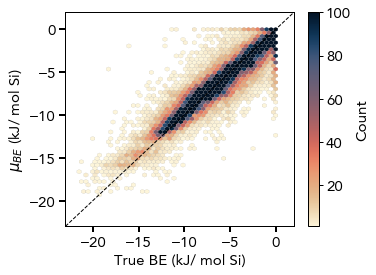

In [29]:
figsize = np.array((13, 10)) * cm
limits = dict(x=(-23, 2), y=(-23, 2))
xticks = range(-25, 2, 5)
yticks = range(-25, 2, 5)
vmin = 1
vmax = 100
gridsize = get_gridsize(limits, 1.)
kwargs = dict(mincnt=1, cmap=cmap_cm.lipari.reversed(), vmin=vmin, vmax=vmax, gridsize=gridsize, linewidth=0.1, edgecolor='grey') # 'viridis_r'

x = iza_truth[iza_truth['SMILES'].isin(splits[1]['test'])]
x = x.set_index(PAIR_COLS)['Binding (SiO2)']
y = iza_preds['be'].set_index(PAIR_COLS)['BE (mean)']
y = y.reindex(x.index)
print("RMSE", round(get_avg_batched_metrics(x, y, rmse), 3))

fig, axs = plt.subplots(figsize=figsize)
sc = axs.hexbin(x, y, **kwargs)
axs = format_axs(axs, 15, 15, 1, "True BE (kJ/ mol Si)", "$\mu_{BE}$ (kJ/ mol Si)", 15, 15, limits=limits, xticks=xticks, yticks=yticks)
cb = get_cb(fig, sc, axs, "Count", ticks=range(0, 101, 20), linewidth=1, tickwidth=1, labelsize=15, labelpad=5)
axs = draw_parity(axs, limits['x'], limits['y']);

pd.concat([x, y], axis=1).to_csv(f"{source_data_dir}/fig_3/a_parity.csv")
save_mpl_fig(fig, main_op_dir + "/test_data_BE_mean_hex", ".svg")

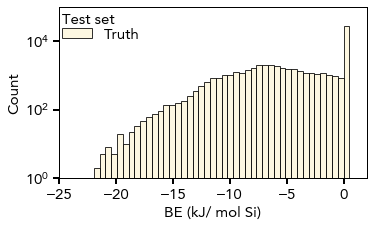

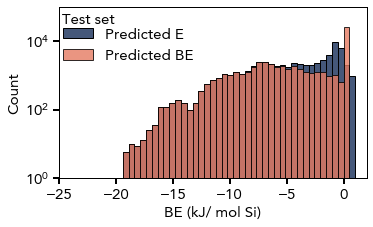

In [30]:
figsize = np.array((14, 8)) * cm
xticks = range(-25, 2, 5)
kwargs = dict(edgecolor='k', linewidth=1, bins=np.linspace(-25, 1, 52), bottom=1) # bottom to fix bugs in illustrator
limits = dict(x=(-25, 2), y=(1e0, 1e5))
colors = get_color_values(10, cmap_cm.lipari)

x = iza_truth[iza_truth['SMILES'].isin(splits[1]['test'])]
x = x.set_index(PAIR_COLS)['Binding (SiO2)']

fig, axs = plt.subplots(figsize=figsize)

sc = axs.hist(x, label='Truth', color=colors[9], alpha=0.8, **kwargs)

axs.set_yscale('log')
axs = format_axs(axs, 15, 15, 1, "BE (kJ/ mol Si)", "Count", 15, 15, xticks=xticks, limits=limits)
leg = get_legend( fig, bbox_to_anchor=(0.23, 0.85), fontsize=15, ncol=1, linewidth=1, edgecolor="k", put_where="fig",)
axs.annotate("Test set", xy=(0.01, 0.9), xycoords='axes fraction', fontsize=15, ha='left')

save_mpl_fig(fig, main_op_dir + "/training_truth_e_dist", ".svg")

########################################################################

y = iza_preds['be'].set_index(PAIR_COLS)['BE (mean)']
y = y.reindex(x.index)

z = iza_preds['energy'].set_index(PAIR_COLS)['Binding (SiO2) (mean)']
z = z.reindex(x.index)

fig, axs = plt.subplots(figsize=figsize)

sc = axs.hist(z, label='Predicted E', color=colors[2], alpha=1.0, **kwargs)
sc = axs.hist(y, label='Predicted BE', color=colors[6], alpha=0.8, **kwargs)

axs.set_yscale('log')
axs = format_axs(axs, 15, 15, 1, "BE (kJ/ mol Si)", "Count", 15, 15, xticks=xticks, limits=limits)
leg = get_legend( fig, bbox_to_anchor=(0.3, 0.85), fontsize=15, ncol=1, linewidth=1, edgecolor="k", put_where="fig",)
axs.annotate("Test set", xy=(0.01, 0.9), xycoords='axes fraction', fontsize=15, ha='left')

save_mpl_fig(fig, main_op_dir + "/training_preds_e_dist", ".svg")

combined = pd.concat([x, y, z], axis=1)
combined.columns = ['Truth', 'Predicted BE', 'Predicted E']
combined.to_csv(f"{source_data_dir}/fig_3/d_energy_distributions.csv")

Average Spearman's rank correlation coefficient: 0.9611474881370391
Average Pearson correlation coefficient: 0.9607899890507677


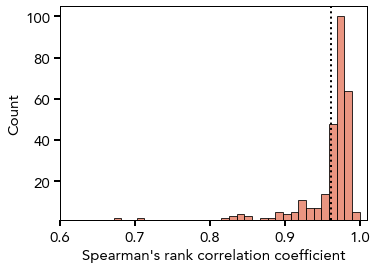

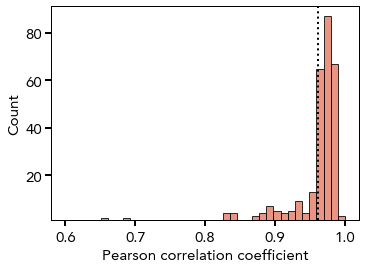

In [31]:
figsize = np.array((14, 10)) * cm
bins= np.linspace(0.6, 1, 40)
xticks=np.linspace(0.6, 1, 5)
limits = dict(x=(0.6, 1.01))
kwargs = dict(edgecolor='k', linewidth=1, bins=bins, alpha=0.8, bottom=1) # bottom to fix bugs in illustrator
colors = get_color_values(10, cmap_cm.lipari)

x = iza_test_ranks['test_spearman']

fig, axs = plt.subplots(figsize=figsize)
sc = axs.hist(x, label='Truth', color=colors[6], **kwargs)
axs = format_axs(axs, 15, 15, 1, "Spearman's rank correlation coefficient", "Count", 15, 15, xticks=xticks, limits=limits)
axs.axvline(x=np.mean(x), color='k', linestyle='dotted', linewidth=2)
print("Average Spearman's rank correlation coefficient:", np.mean(x))

save_mpl_fig(fig, main_op_dir + "/test_data_spearman", ".svg")

########################################################################

x = iza_test_ranks['test_pearson']

fig, axs = plt.subplots(figsize=figsize)
sc = axs.hist(x, label='E only', color=colors[6], **kwargs)
axs = format_axs(axs, 15, 15, 1, "Pearson correlation coefficient", "Count", 15, 15, xticks=xticks)
axs.axvline(x=np.mean(x), color='k', linestyle='dotted', linewidth=2);
print("Average Pearson correlation coefficient:", np.mean(x))

save_mpl_fig(fig, main_op_dir + "/test_data_pearson", ".svg")

# Uncertainty

## Uncertainty plots
- Here, we plot $V_{mol}-BE$ plots colored by the standard deviation of BE as a measure of uncertainty

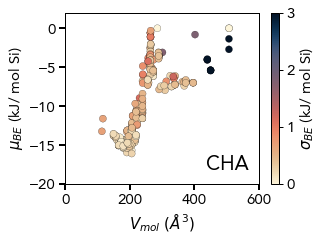

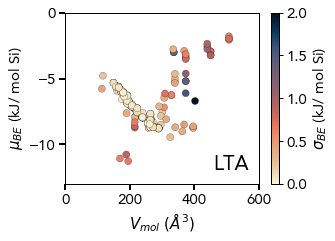

In [176]:
figsize = np.array((11, 8)) * cm
kwargs = dict(s=50, alpha=1.0, linewidth=0.2, edgecolor='k', cmap=cmap_cm.lipari.reversed())

# getting test set
t = iza_truth[iza_truth['SMILES'].isin(splits[1]['test'])]
t = t.set_index(PAIR_COLS)['Binding (SiO2)']
yy = iza_preds['be'].set_index(PAIR_COLS)
yy = yy.reindex(t.index)

# getting specific fw (1)
fw = 'CHA'
limits = dict(x=(0, 600), y=(-20, 2))
xticks = range(0, 601, 200)
yticks = range(-20, 2, 5)
kwargs['vmin'] = 0
kwargs['vmax'] = 3
y = yy[yy.index.get_level_values(PAIR_COLS[0]) == fw]
c = y['BE (std)']
y = y['BE (mean)']
x = iza_opriors.reindex(y.index.get_level_values(PAIR_COLS[1]))['mol_volume']

fig, axs = plt.subplots(figsize=figsize)
sc = axs.scatter(x, y, c=c, **kwargs)
axs = format_axs(axs, 15, 15, 1, "$V_{mol} \; (\AA^3)$", "$\mu_{BE}$ (kJ/ mol Si)", 15, 15, limits=limits, xticks=xticks, yticks=yticks)
cb = get_cb(fig, sc, axs, "$\sigma_{BE}$ (kJ/ mol Si)", ticks=range(0, 4, 1), linewidth=1, tickwidth=1, labelsize=15, labelpad=5)
# annotate bottom right the fw 
axs.annotate(fw, xy=(0.95, 0.05), xycoords='axes fraction', fontsize=20, ha='right', va='bottom')

pd.concat([x, y, c], axis=1).to_csv(f"{source_data_dir}/fig_3/e_vol_unc_{fw}.csv")
save_mpl_fig(fig, main_op_dir + f"/be_vol_unc_{fw}", ".svg")

########################################################################

# getting specific fw (2)
fw = 'LTA'
limits = dict(x=(0, 600), y=(-13, 0))
xticks = range(0, 601, 200)
yticks = range(-20, 1, 5)
kwargs['vmin'] = 0
kwargs['vmax'] = 2
y = yy[yy.index.get_level_values(PAIR_COLS[0]) == fw]
c = y['BE (std)']
y = y['BE (mean)']
x = iza_opriors.reindex(y.index.get_level_values(PAIR_COLS[1]))['mol_volume']

fig, axs = plt.subplots(figsize=figsize)
sc = axs.scatter(x, y, c=c, **kwargs)
axs = format_axs(axs, 15, 15, 1, "$V_{mol} \; (\AA^3)$", "$\mu_{BE}$ (kJ/ mol Si)", 15, 15, limits=limits, xticks=xticks, yticks=yticks)
cb = get_cb(fig, sc, axs, "$\sigma_{BE}$ (kJ/ mol Si)", ticks=np.linspace(0, 2, 5), linewidth=1, tickwidth=1, labelsize=15, labelpad=5)
# annotate bottom right the fw 
axs.annotate(fw, xy=(0.95, 0.05), xycoords='axes fraction', fontsize=20, ha='right', va='bottom');

pd.concat([x, y, c], axis=1).to_csv(f"{source_data_dir}/fig_3/e_vol_unc_{fw}.csv")
save_mpl_fig(fig, main_op_dir + f"/be_vol_unc_{fw}", ".svg")

## RMSE-uncertainty plots
- We compare the correlation between error and uncertainty using 3 sets of molecules that are increasingly out-of-distribution (OOD): test set molecules, a randomly selected set of hypothetical monoquaternary molecules, and a randomly selected set of hypothetical diquaternary molecules.
- The ensembling method used here is the same as the ensembling method used for screening.

In [78]:
# reverse order
cols = rmse_unc.columns[::-1]

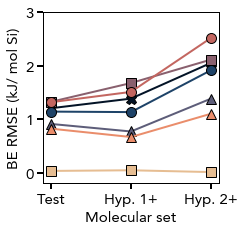

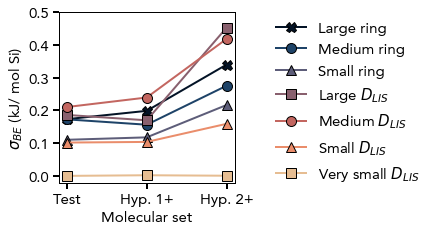

In [ ]:
figsize = np.array((8, 8)) * cm
kwargs = dict(alpha=1.0, markersize=10, linewidth=2.0, markeredgecolor='k')
colors = get_color_values(8, cmap_cm.lipari) 
markers = ['X', 'o', '^', 's', 'o', '^', 's']
xticks = ['Test', 'Hyp. 1+', 'Hyp. 2+']
labels = ['Very small $D_{LIS}$', 'Small $D_{LIS}$', 'Medium $D_{LIS}$', 'Large $D_{LIS}$', 'Small ring', 'Medium ring', 'Large ring']
labels = ['Large ring', 'Medium ring', 'Small ring','Large $D_{LIS}$','Medium $D_{LIS}$', 'Small $D_{LIS}$', 'Very small $D_{LIS}$',]
# Plot RMSE

fig, axs = plt.subplots(figsize=figsize)
for i, c in enumerate(cols):
    x = rmse_unc[c].loc[['test_rmse', 'mono_rmse', 'diq_rmse']]
    axs.plot(x, color=colors[i], marker=markers[i], label=labels[i], **kwargs)
axs = format_axs(axs, 15, 15, 1, "Molecular set", "BE RMSE (kJ/ mol Si)", 15, 15)
axs.set_xticklabels(xticks)
axs.set_ylim(-0.2, 3)
# leg = get_legend(fig, bbox_to_anchor=bbox_to_anchor, fontsize=15, ncol=1, linewidth=1, edgecolor="k", put_where="fig",)

save_mpl_fig(fig, main_op_dir + "/rmse_mol", ".svg") 

########################################################################

# Plot Uncertainty

bbox_to_anchor = (1.4, 0.9)

fig, axs = plt.subplots(figsize=figsize)
for i, c in enumerate(cols):
    x = rmse_unc[c].loc[['test_unc', 'mono_unc', 'diq_unc']]
    axs.plot(x, color=colors[i], marker=markers[i], label=labels[i], **kwargs)
axs = format_axs(axs, 15, 15, 1, "Molecular set", "$\sigma_{BE}$ (kJ/ mol Si)", 15, 15, yticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5])
axs.set_xticklabels(xticks)
leg = get_legend(fig, bbox_to_anchor=bbox_to_anchor, fontsize=15, ncol=1, linewidth=2, edgecolor="k", put_where="fig",)

save_mpl_fig(fig, main_op_dir + "/unc_mol", ".svg") 

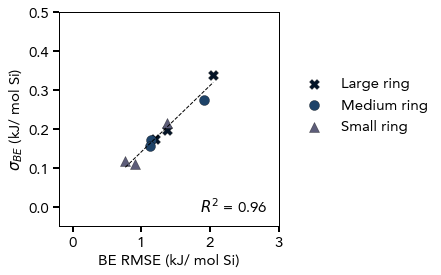

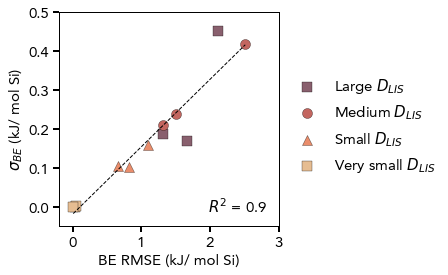

In [188]:
# Plot correlation plots between accuracy and uncertainty for different pore sizes 
figsize = np.array((10, 10)) * cm
kwargs = dict(alpha=1.0, s=100, linewidth=0.3, edgecolor='k')
bbox_to_anchor = (1.2, 0.7)

fig, axs = plt.subplots(figsize=figsize)
xes = []; yes = [] 
for i, c in enumerate(cols):
    if 'ring' in c:
        x = rmse_unc[c].loc[['test_rmse', 'mono_rmse', 'diq_rmse']]
        y = rmse_unc[c].loc[['test_unc', 'mono_unc', 'diq_unc']]
        axs.scatter(x, y, color=colors[i], marker=markers[i], label=labels[i], **kwargs)
        xes.extend(x.tolist())
        yes.extend(y.tolist())
axs = format_axs(axs, 15, 15, 1, "BE RMSE (kJ/ mol Si)", "$\sigma_{BE}$ (kJ/ mol Si)", 15, 15)
axs.set_ylim(-0.05, 0.5)
axs.set_xlim(-0.2, 3)
leg = get_legend(fig, bbox_to_anchor=bbox_to_anchor, fontsize=15, ncol=1, linewidth=1, edgecolor="k", put_where="fig",)
# get best fit line 
m, b = np.polyfit(xes, yes, 1)
axs.plot(sorted(xes), m*np.array(sorted(xes)) + b, color='k', linestyle='--', linewidth=1);
r2 = r2_score(yes, m*np.array(xes) + b)
axs.annotate(f"$R^2$ = {round(r2, 2)}", xy=(0.95, 0.05), xycoords='axes fraction', fontsize=15, ha='right', va='bottom')

fig, axs = plt.subplots(figsize=figsize)
xes = []; yes = [] 
for i, c in enumerate(cols):
    if not 'ring' in c:
        x = rmse_unc[c].loc[['test_rmse', 'mono_rmse', 'diq_rmse']]
        y = rmse_unc[c].loc[['test_unc', 'mono_unc', 'diq_unc']]
        axs.scatter(x, y, color=colors[i], marker=markers[i], label=labels[i], **kwargs)
        xes.extend(x.tolist())
        yes.extend(y.tolist())
axs = format_axs(axs, 15, 15, 1, "BE RMSE (kJ/ mol Si)", "$\sigma_{BE}$ (kJ/ mol Si)", 15, 15)
axs.set_ylim(-0.05, 0.5)
axs.set_xlim(-0.2, 3)
leg = get_legend(fig, bbox_to_anchor=bbox_to_anchor, fontsize=15, ncol=1, linewidth=1, edgecolor="k", put_where="fig",)
# get best fit line 
m, b = np.polyfit(xes, yes, 1)
axs.plot(sorted(xes), m*np.array(sorted(xes)) + b, color='k', linestyle='--', linewidth=1);
r2 = r2_score(yes, m*np.array(xes) + b)
axs.annotate(f"$R^2$ = {round(r2, 2)}", xy=(0.95, 0.05), xycoords='axes fraction', fontsize=15, ha='right', va='bottom');

## Calibration of prediction uncertainty

In [189]:
def format_df(preds, stds, truth, index_cols=PAIR_COLS):
    preds = preds.reset_index()
    preds = preds.rename(columns={"index": "Zeolite", "0": "mean_be"}, )
    preds = preds.drop_duplicates(subset=PAIR_COLS)
    preds = preds.set_index(PAIR_COLS, )

    stds = stds.reset_index()
    stds = stds.rename(columns={"index": "Zeolite", "0": "std_be"}, )
    stds = stds.drop_duplicates(subset=PAIR_COLS)
    stds = stds.set_index(PAIR_COLS, )

    preds["std_be"] = stds.loc[preds.index, "std_be"].values

    intersection_idx = preds.index.intersection(truth.set_index(PAIR_COLS).index)
    preds = preds.loc[intersection_idx]
    preds["true_be"] = truth.set_index(PAIR_COLS).loc[intersection_idx, "Binding (SiO2)"].values
    return preds 

calibration_set = format_df(iza_preds["mean_be"].copy(), iza_preds["std_be"].copy(), iza_truth.copy())
evaluation_set = format_df(heldout_preds["mean_be"].copy(), heldout_preds["std_be"].copy(), heldout_truth.copy())

Non conformity score used: std_dev_weighted_abs_err


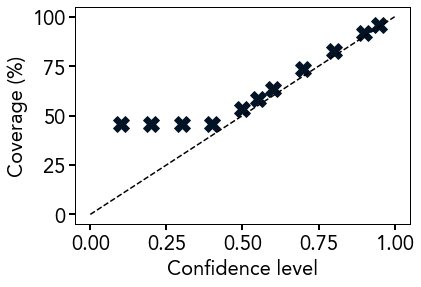

In [192]:
def get_non_conformity_score(x, y, score, std_dev=None):
    if score == "abs_err":
        return np.abs(x - y)
    elif score == "err":
        return x - y
    elif score == "std_dev_weighted_abs_err":
        return np.abs(x - y) / (std_dev + 1e-6)
    else:
        raise ValueError("Invalid non-conformity score")

def ncscore_within_bounds(x, lower_bound, upper_bound):
    return (x >= lower_bound) & (x <= upper_bound)

# get NC scores
non_conformity_score="std_dev_weighted_abs_err"
print("Non conformity score used:", non_conformity_score)
calibration_set["non_conformity_score"] = get_non_conformity_score(
    calibration_set["true_be"], 
    calibration_set["mean_be"], 
    non_conformity_score, 
    std_dev=calibration_set["std_be"]
    )
evaluation_set["non_conformity_score"] = get_non_conformity_score(
    evaluation_set["true_be"], 
    evaluation_set["mean_be"], 
    non_conformity_score, 
    std_dev=evaluation_set["std_be"]
    )

def conformal_prediction_analysis(confidence=0.95,):

    quantile_index = int((1 - confidence) * (len(calibration_set) + 1)) - 1 
    sorted_scores = np.sort(calibration_set["non_conformity_score"].values)[::-1]
    width = sorted_scores[quantile_index]

    evaluation_set["pred_upper"] = evaluation_set["mean_be"] + width * evaluation_set["std_be"]
    evaluation_set["pred_lower"] = evaluation_set["mean_be"] - width * evaluation_set["std_be"]
    evaluation_set["ci"] = evaluation_set["pred_upper"] - evaluation_set["pred_lower"]
    evaluation_set["within_bounds"] = (evaluation_set["true_be"] >= evaluation_set["pred_lower"]) & (evaluation_set["true_be"] <= evaluation_set["pred_upper"])

    x = evaluation_set[evaluation_set.within_bounds == True]['non_conformity_score']
    return len(x) / len(evaluation_set) * 100

within_bounds = dict()
for confidence in [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.7, 0.8, 0.9, 0.95]:
    within_bounds[confidence] = conformal_prediction_analysis(confidence=confidence)

fig, axs = plt.subplots() 
axs.scatter(within_bounds.keys(), within_bounds.values(), color=colors[0], marker="X", s=250)
axs = format_axs(axs, 20, 20, 1, "Confidence level", "Coverage (%)", 20, 20)
axs.plot([0, 1.0], [0, 100], "k--");

In [258]:
x = calibration_set[calibration_set.true_be == 0.0]
print(f"Fraction of non-binding pairs: {x.shape[0] / len(calibration_set):.3f}")
print(f"Fraction of non-binding pairs correctly predicted in calibration set: {calibration_set[(calibration_set.mean_be == 0.0) & (calibration_set.true_be == 0.0)].shape[0] / x.shape[0]:.3f}")

x = evaluation_set[evaluation_set.true_be == 0.0]
print(f"Fraction of non-binding pairs: {x.shape[0] / len(evaluation_set):.3f}")
print(f"Fraction of non-binding pairs correctly predicted in evaluation set: {evaluation_set[(evaluation_set.mean_be == 0.0) & (evaluation_set.true_be == 0.0)].shape[0] / x.shape[0]:.3f}")

Fraction of non-binding pairs: 0.453
Fraction of non-binding pairs correctly predicted in calibration set: 0.940
Fraction of non-binding pairs: 0.512
Fraction of non-binding pairs correctly predicted in evaluation set: 0.889


# PCA plot of molecular sets

In [193]:
# plot PCA plot 

scaler = StandardScaler()
pca = PCA(n_components=2)

# get the features
s1 = iza_opriors.loc[np.concatenate([splits[1]['train'], splits[1]['val']])][ofeatures]
s2 = iza_opriors.loc[splits[1]['test']][ofeatures]

heldout_mono_smiles = list(set(heldout_truth[heldout_truth.charge == 1]['SMILES']))
heldout_diq_smiles = list(set(heldout_truth[heldout_truth.charge == 2]['SMILES']))
s3 = heldout_opriors.loc[heldout_mono_smiles][ofeatures]
s4 = heldout_opriors.loc[heldout_diq_smiles][ofeatures]

s1_scaled = scaler.fit_transform(s1)
s2_scaled = scaler.transform(s2)
s3_scaled = scaler.transform(s3)
s4_scaled = scaler.transform(s4)

pca1 = pca.fit_transform(s1_scaled)
pca2 = pca.transform(s2_scaled)
pca3 = pca.transform(s3_scaled)
pca4 = pca.transform(s4_scaled)

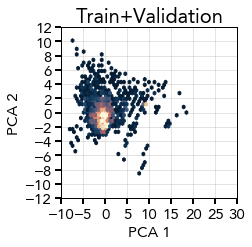

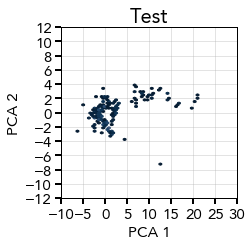

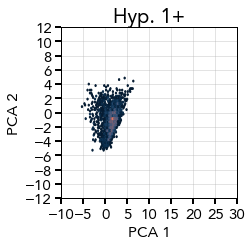

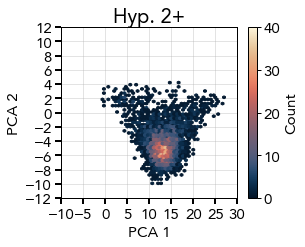

In [200]:
figsize = np.array((8, 8)) * cm
limits = dict(x=(-10, 30), y=(-12, 12))
xticks = range(limits['x'][0], limits['x'][1]+1, 5)
yticks = range(limits['y'][0], limits['y'][1]+1, 2)
vmin = 0
vmax = 40
gridsize = get_gridsize(limits, 1)
kwargs = dict(mincnt=1, cmap=cmap_cm.lipari, vmin=vmin, vmax=vmax, gridsize=gridsize, )#linewidth=0.1, edgecolor='k')
labels = ['Train+Validation', 'Test', 'Hyp. 1+', 'Hyp. 2+']
file_labels = ['train_val', 'test', 'hyp_mono', 'hyp_diq']

for i, (s, pc) in enumerate(
    zip(
        [s1.index, s2.index, s3.index, s4.index], 
        [pca1, pca2, pca3, pca4]
        )):
    if i == 3:
        fig, axs = plt.subplots(figsize=np.array((10, 8)) * cm)
    else: 
        fig, axs = plt.subplots(figsize=figsize)

    # add a grid 
    axs.grid(linewidth=0.5, alpha=0.7, )
    axs.set_axisbelow(True)

    sc = axs.hexbin(pc[:, 0], pc[:, 1], **kwargs)
    axs = format_axs(axs, 15, 15, 1, "PCA 1", "PCA 2", 15, 15, limits=limits, xticks=xticks, yticks=yticks)

    if i == 3:
        cb = get_cb(fig, sc, axs, "Count", ticks=range(vmin, vmax+1, 10), linewidth=1, tickwidth=1, labelsize=15, labelpad=5)

    # annotate 
    axs.annotate(labels[i], xy=(0.5, 1.12), xycoords='axes fraction', fontsize=20, ha='center', va='top')

    save_mpl_fig(fig, main_op_dir + f"/pca_{file_labels[i]}", ".svg")
    pd.DataFrame(pc, index=s, columns=["PCA 1", "PCA 2"]).to_csv(f"{source_data_dir}/fig_2/f_pca_{file_labels[i]}.csv")